Load modules

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

Hyperparameters

In [2]:
n_epoch = 500
batch_size = 32
lr = 1e-3

Dataset

In [3]:
n_point = 100
n_center = 10
pts, labels = [], [] 
center_pts = np.random.uniform(-12, 12, (n_center, 2))

for label, center_pt in enumerate(center_pts):
    for _ in range(n_point):
        pts.append(center_pt + np.random.randn(*center_pt.shape))
        labels.append(label)
pts = np.stack(pts, axis = 0).astype(np.float32)
labels = np.stack(labels,axis = 0)

Preprocessing

In [4]:
train_ds = tf.data.Dataset.from_tensor_slices((pts, labels)).shuffle(1000).batch(batch_size)

Network

In [5]:
class DNN(tf.keras.Model):
    def __init__(self, n_units, activation = 'relu'):
        super(DNN, self).__init__()
        #---- Arguemnt ----#
        self.n_units = n_units
        self.L = len(self.n_units)
        self.activation = activation
        self.layer_lst = []
        #---- Dense Layer ----#
        for i in range(self.L):
            if i<self.L-2:
                in_dim, out_dim = self.n_units[i], self.n_units[i+1]
                act = self.activation
            elif i==self.L-2:
                in_dim, out_dim = self.n_units[i], self.n_units[i+1]
                act = 'softmax'
            else:
                break        
            layer = layers.Dense(out_dim,
                                 input_dim = in_dim,
                                 activation = act) 
            self.layer_lst.append(layer)
        
    def call(self,x, training = None, mask = None):
        for layer in self.layer_lst:
            x = layer(x)
        return x

model = DNN(n_units = [2, 512, n_center], activation = 'relu')

Loss function &  Optimizer  &  Metrics

In [6]:
criterion = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(lr = lr)
train_metric = tf.keras.metrics.SparseCategoricalAccuracy(name = 'Training Loss')
train_loss = tf.keras.metrics.Mean(name = 'Training Accuracy')

Training Function

In [7]:
@tf.function
def train(model, inputs, outputs, criterion,
          optimizer, train_loss, train_metric):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = criterion(outputs, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)
    train_metric(outputs, predictions)

Training Loop

In [8]:
t_loss, t_metric = [], []
for epoch in tqdm(range(n_epoch)):
    loss_lst, metric_lst = [], []
    for batch in train_ds:
        pts, labels = batch
        train(model = model, inputs = pts,
                outputs = labels, criterion = criterion,
                optimizer = optimizer, train_loss = train_loss,
                train_metric = train_metric)
        t_loss.append(train_loss.result().numpy())
        t_metric.append(train_metric.result().numpy())

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:16<00:00, 29.84it/s]


Evaluation

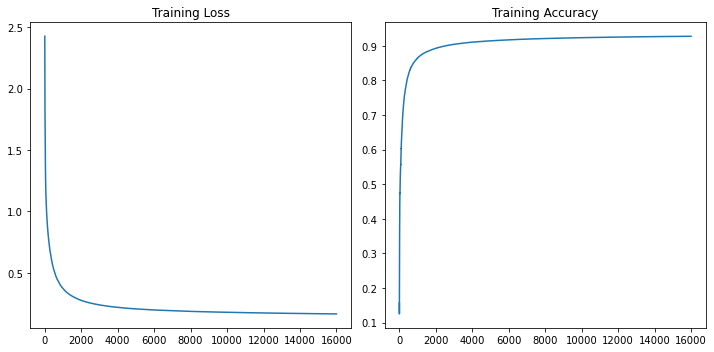

In [9]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].plot(t_loss)
ax[0].set_title('Training Loss')
ax[1].plot(t_metric)
ax[1].set_title('Training Accuracy')
plt.tight_layout()
plt.show()